In [6]:
import pandas as pd
import os
import glob
import numpy as np
pd.options.mode.copy_on_write=True

In [7]:
'''df_2020 = pd.read_parquet( "../src/data/2020_Accidentalidad_Limpio.parquet", engine="pyarrow" )

df_2021 = pd.read_parquet( "../src/data/2021_Accidentalidad_Limpio.parquet", engine="pyarrow" )'''

df_2022 = pd.read_parquet( "../src/data/2022_Accidentalidad_Limpio.parquet", engine="pyarrow" )

df_2023 = pd.read_parquet( "../src/data/2023_Accidentalidad_Limpio.parquet", engine="pyarrow" )

df_2024 = pd.read_parquet( "../src/data/2024_Accidentalidad_Limpio.parquet", engine="pyarrow" )



In [8]:
'''df_2020["origen"] = "2020"
df_2021["origen"] = "2021"'''
df_2022["origen"] = "2022"
df_2023["origen"] = "2023"
df_2024["origen"] = "2024"


In [15]:
df_accidentes = pd.concat(
    [ df_2022, df_2023, df_2024],
    ignore_index=True
)


In [16]:
df_accidentes.info()
df_accidentes.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139136 entries, 0 to 139135
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   num_expediente        139136 non-null  object        
 1   fecha                 139136 non-null  datetime64[ns]
 2   hora                  139136 non-null  object        
 3   localizacion          139136 non-null  object        
 4   numero                139136 non-null  object        
 5   cod_distrito          139136 non-null  float64       
 6   distrito              139136 non-null  category      
 7   tipo_accidente        139136 non-null  object        
 8   estado_meteorológico  139136 non-null  object        
 9   tipo_vehiculo         139136 non-null  object        
 10  tipo_persona          139136 non-null  category      
 11  rango_edad            139136 non-null  category      
 12  sexo                  139136 non-null  category      
 13 

,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,...,sexo,cod_lesividad,lesividad,coordenada_x_utm,coordenada_y_utm,positiva_alcohol,fecha_hora,grado_lesividad,franja_horaria,origen
0,2022s000001,2022-01-01,01:30:00,"avda. albufera, 19",19,13.0,PUENTE DE VALLECAS,Alcance,Despejado,Turismo,...,Mujer,14.0,Sin asistencia sanitaria,443359.0,4472082.0,Negativo,2022-01-01 01:30:00,Sin asistencia sanitaria,Madrugada,2022
1,2022s000001,2022-01-01,01:30:00,"avda. albufera, 19",19,13.0,PUENTE DE VALLECAS,Alcance,Despejado,Turismo,...,Hombre,14.0,Sin asistencia sanitaria,443359.0,4472082.0,Negativo,2022-01-01 01:30:00,Sin asistencia sanitaria,Madrugada,2022
2,2022s000002,2022-01-01,00:30:00,plaza. canovas del castillo / paseo. prado,2,3.0,RETIRO,Colisión fronto-lateral,Se desconoce,Motocicleta hasta 125cc,...,Hombre,14.0,Sin asistencia sanitaria,441155.0,4474129.0,Positivo,2022-01-01 00:30:00,Sin asistencia sanitaria,Madrugada,2022
3,2022s000002,2022-01-01,00:30:00,plaza. canovas del castillo / paseo. prado,2,3.0,RETIRO,Colisión fronto-lateral,Se desconoce,Motocicleta hasta 125cc,...,Mujer,14.0,Sin asistencia sanitaria,441155.0,4474129.0,Negativo,2022-01-01 00:30:00,Sin asistencia sanitaria,Madrugada,2022
4,2022s000002,2022-01-01,00:30:00,plaza. canovas del castillo / paseo. prado,2,3.0,RETIRO,Colisión fronto-lateral,Se desconoce,Turismo,...,Hombre,14.0,Sin asistencia sanitaria,441155.0,4474129.0,Negativo,2022-01-01 00:30:00,Sin asistencia sanitaria,Madrugada,2022


In [17]:
def preparar_accidentes_unicos(df, col_id='num_expediente'):
    """
    Devuelve un DataFrame con accidentes únicos (1 fila = 1 expediente),
    agregando variables relevantes y derivando variables temporales.
    """

    # Asegurar datetime
    df['fecha_hora'] = pd.to_datetime(df['fecha_hora'], errors='coerce')

    # Agregación por expediente
    df_unicos = df.groupby(col_id).agg({
        'fecha_hora': 'min',
        'tipo_accidente': 'first',
        'tipo_vehiculo': lambda x: list(x.unique()),
        'distrito': 'first',
        'estado_meteorológico': 'first',
        'rango_edad': 'first',
        'tipo_persona': 'first',
        'sexo': 'first',
        'positiva_alcohol': 'first'
    }).reset_index()

    # Variables temporales
    df_unicos['año'] = df_unicos['fecha_hora'].dt.year
    df_unicos['mes'] = df_unicos['fecha_hora'].dt.month
    df_unicos['dia_semana'] = df_unicos['fecha_hora'].dt.day_name()
    df_unicos['hora'] = df_unicos['fecha_hora'].dt.hour

    df_unicos['franja'] = pd.cut(
        df_unicos['hora'],
        bins=[0,6,12,18,24],
        labels=['Madrugada','Mañana','Tarde','Noche'],
        right=False
    )

    return df_unicos


In [18]:
import matplotlib.pyplot as plt
import pandas as pd

def curva_mensual_multianual(df, col_datetime="fecha_hora"):
    """
    Genera una única gráfica con la frecuencia mensual de accidentes,
    mostrando una línea por cada año presente en el DataFrame.
    """

    # Asegurar datetime
    df[col_datetime] = pd.to_datetime(df[col_datetime], errors="coerce")

    # Agrupar por año y mes → tabla año × mes
    tabla = (
        df.groupby([df[col_datetime].dt.year, df[col_datetime].dt.month])
          .size()
          .unstack(fill_value=0)
    )

    # Nombres de meses
    meses_es = [
        "Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio",
        "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"
    ]
    tabla.columns = meses_es[:len(tabla.columns)]

    # Crear figura
    plt.figure(figsize=(14, 6))

    # Dibujar una línea por año
    for año in tabla.index:
        plt.plot(
            tabla.columns,
            tabla.loc[año],
            marker="o",
            linewidth=3,
            label=str(año)
        )

        # Etiquetas encima de cada punto
        for i, v in enumerate(tabla.loc[año]):
            plt.text(i, v + 5, str(v), ha="center", fontsize=8)

    # Estética
    plt.title("Curva mensual de accidentes por año", fontsize=14)
    plt.xlabel("Mes")
    plt.ylabel("Número de accidentes")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(title="Año")
    plt.tight_layout()
    plt.show()


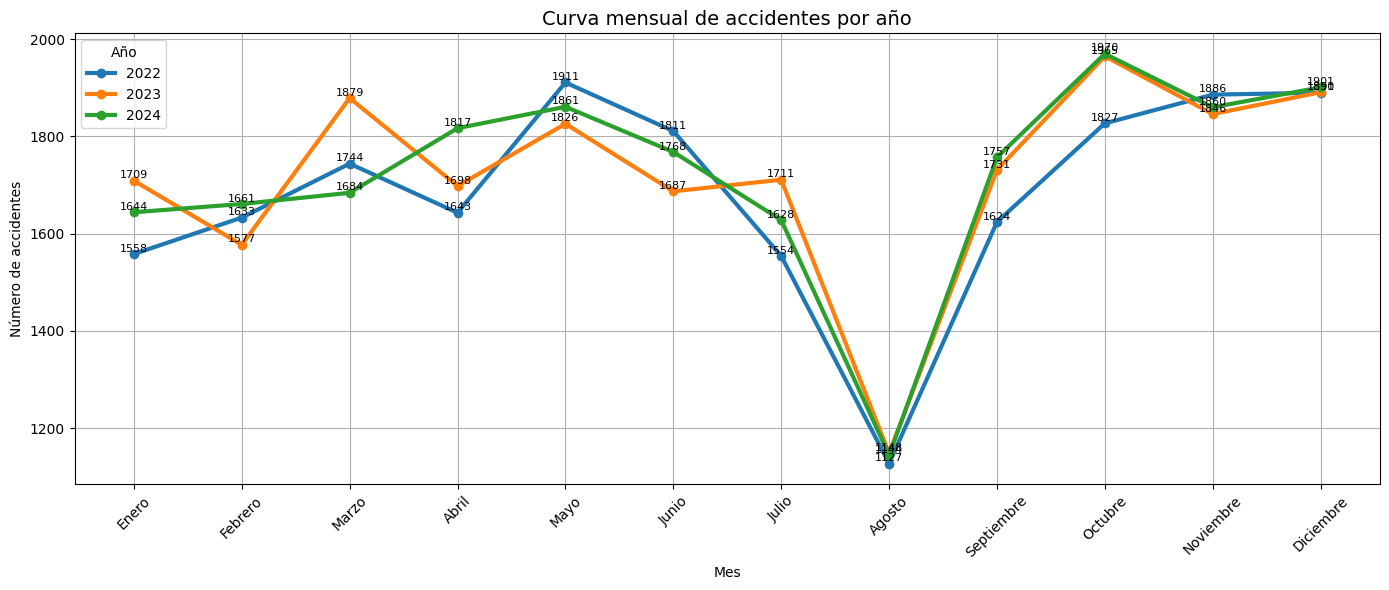

In [19]:
df_unicos = preparar_accidentes_unicos(df_accidentes)
curva_mensual_multianual(df_unicos)
